### Fifa 22 Complete Player df_mainset [UPD:01/10/21]

##### Content

Replaced positions that do not exist in fifa, for example ["LS", "RS"] with "ST".
And a few more brief introductory notes:

- monetary values in Euro;
- height in cm;
- weight in kg;
- players without clubs in the Clubs column - "Free agent"
- players who are not include to national teams in the column "NationalTeam" - "Not in team"

---

##### Hypotesis
- **Hypothesis 1**: Players with higher potential ratings are typically younger and command a higher market value.
- **Hypothesis 2**: The overall rating of a player is strongly correlated with their market value and wage.

- **Question 1**: Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?
- **Question 2**: What are the key attributes that differentiate high-value players from lower-value players?
- **Question 3**: How does a player's physical attributes, such as height and weight, correlate with their overall and potential ratings?



In [35]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('players_fifa22.csv')

#### Checking what columns we have in the dataset

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19260 entries, 0 to 19259
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 19260 non-null  int64  
 1   Name               19260 non-null  object 
 2   FullName           19260 non-null  object 
 3   Age                19260 non-null  int64  
 4   Height             19260 non-null  int64  
 5   Weight             19260 non-null  int64  
 6   PhotoUrl           19260 non-null  object 
 7   Nationality        19260 non-null  object 
 8   Overall            19260 non-null  int64  
 9   Potential          19260 non-null  int64  
 10  Growth             19260 non-null  int64  
 11  TotalStats         19260 non-null  int64  
 12  BaseStats          19260 non-null  int64  
 13  Positions          19260 non-null  object 
 14  BestPosition       19260 non-null  object 
 15  Club               19260 non-null  object 
 16  ValueEUR           192

In [38]:

# 3df.iloc[:, 30:]
df.describe()

ID           Age        Height        Weight       Overall  \
count   19260.000000  19260.000000  19260.000000  19260.000000  19260.000000   
mean   231682.741952     25.184683    181.305036     74.950779     65.815628   
std     26960.272515      4.737340      6.866151      7.066864      6.817297   
min        41.000000     16.000000    155.000000     49.000000     48.000000   
25%    214903.500000     21.000000    176.000000     70.000000     62.000000   
50%    236687.500000     25.000000    181.000000     75.000000     66.000000   
75%    253607.500000     29.000000    186.000000     80.000000     70.000000   
max    264705.000000     54.000000    206.000000    110.000000     93.000000   

          Potential        Growth    TotalStats     BaseStats      ValueEUR  \
count  19260.000000  19260.000000  19260.000000  19260.000000  1.926000e+04   
mean      71.100104      5.284476   1598.525909    357.062461  2.857652e+06   
std        6.092103      5.472201    271.575855     39.910613  7.604532e+06   
min       49.000000      0.000000    767.000000    227.000000  0.000000e+00   
25%       67.000000      0.000000   1462.000000    329.000000  4.750000e+05   
50%       71.000000      4.000000   1633.000000    358.000000  9.750000e+05   
75%       75.000000      9.000000   1782.000000    384.000000  2.000000e+06   
max       95.000000     26.000000   2341.000000    501.000000  1.940000e+08   

       ...      LMRating      CMRating      RMRating     LWBRating  \
count  ...  19260.000000  19260.000000  19260.000000  19260.000000   
mean   ...     58.364434     57.227207     58.364434     56.197040   
std    ...     13.989045     13.212152     13.989045     13.818416   
min    ...     17.000000     17.000000     17.000000     17.000000   
25%    ...     54.000000     52.000000     54.000000     51.000000   
50%    ...     62.000000     60.000000     62.000000     59.000000   
75%    ...     67.000000     66.000000     67.000000     65.000000   
max    ...     93.000000     91.000000     93.000000     88.000000   

          CDMRating     RWBRating      LBRating      CBRating      RBRating  \
count  19260.000000  19260.000000  19260.000000  19260.000000  19260.000000   
mean      55.771340     56.197040     55.539823     54.379595     55.539823   
std       13.856922     13.818416     14.063862     14.678658     14.063862   
min       18.000000     17.000000     16.000000     18.000000     16.000000   
25%       48.000000     51.000000     49.000000     44.000000     49.000000   
50%       59.000000     59.000000     59.000000     58.000000     59.000000   
75%       66.000000     65.000000     65.000000     66.000000     65.000000   
max       90.000000     88.000000     88.000000     89.000000     88.000000   

           GKRating  
count  19260.000000  
mean      23.242939  
std       15.053823  
min       10.000000  
25%       17.000000  
50%       18.000000  
75%       20.000000  
max       92.000000  

[8 rows x 76 columns]

#### Checking missing values

In [39]:
df.isna().sum().sort_values(ascending=False)

NationalNumber       18503
NationalPosition     18503
ClubNumber              76
ContractUntil           76
ClubPosition            76
                     ...  
DefensiveWorkRate        0
AttackingWorkRate        0
SkillMoves               0
WeakFoot                 0
GKRating                 0
Length: 90, dtype: int64

#### Selecting relevant columns
- Since this dataset consists of 90 columns so I will exclude all the columns I think are irrelevant for my hypotheses.
- There are no missing values.
##### Column meanings
- I've never played FIFA so im going to guess what these stats mean.
    - `Overall` = Final evaluation of players skills.
    - `Potential` = Players potential
    - `Growth` = Difference between Potential and Overall
    - `TotalStats` = Maximum skills the player can achieve.
    - `BaseStats` = Skills the player starts with.
    - `SkillMoves` = Determines how many tricks the player can pull off (creativity during play? IRL).
- I'm also going to assume that the stats are based or at least inspired by the real life players.

In [47]:
df_main = df.copy()
df_main = df_main.loc[:, ['Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth', 'TotalStats', 'BaseStats', 'ValueEUR', 'WageEUR', 'SkillMoves', 'PaceTotal', 'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal']]
df_main.isna().sum().sort_values(ascending=False)
df_main.describe()


# check if TotalStats is the sum of skill stats
TotalStats_check = df_main['PaceTotal'] + df_main['ShootingTotal'] + df_main['PassingTotal'] + df_main['DribblingTotal'] + df_main['DefendingTotal'] + df_main['PhysicalityTotal'] == df_main['TotalStats']
TotalStats_check

0        False
1        False
2        False
3        False
4        False
         ...  
19255    False
19256    False
19257    False
19258    False
19259    False
Length: 19260, dtype: bool

##### 

#### Let's take a look at distributions
- As expected `Age` is skewed to the left, most players tend to be younger with ages between 20 and 28
- `Overall` and `Potential` has normal distribution
- `Growth` ratings is in most cases 0, meaning that only a few of the players actually improve significantly.

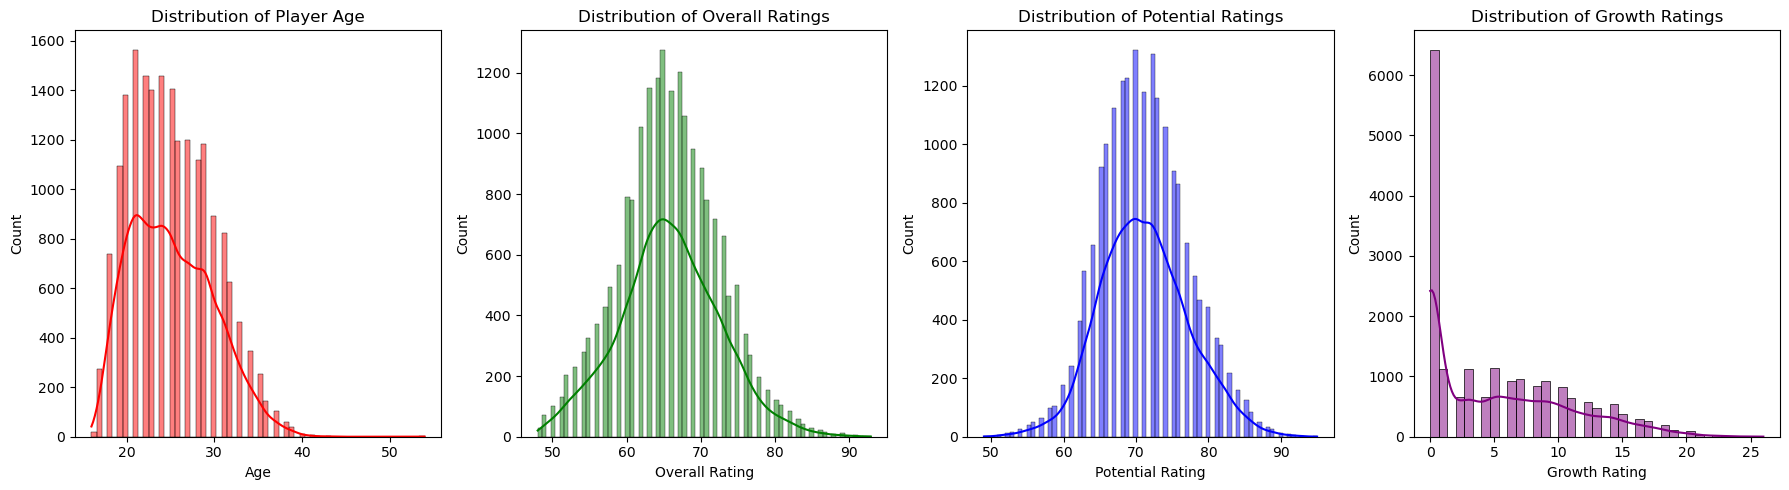

In [91]:

# Plot distribution of Age, Overall, and Potential
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(df_main['Age'], kde=True, ax=axes[0], color='red')
axes[0].set_title('Distribution of Player Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sns.histplot(df_main['Overall'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Overall Ratings')
axes[1].set_xlabel('Overall Rating')

sns.histplot(df_main['Potential'], kde=True, ax=axes[2], color='blue')
axes[2].set_title('Distribution of Potential Ratings')
axes[2].set_xlabel('Potential Rating')

sns.histplot(df_main['Growth'], kde=True, ax=axes[3], color='purple')
axes[3].set_title('Distribution of Growth Ratings')
axes[3].set_xlabel('Growth Rating')

plt.tight_layout()
plt.show()


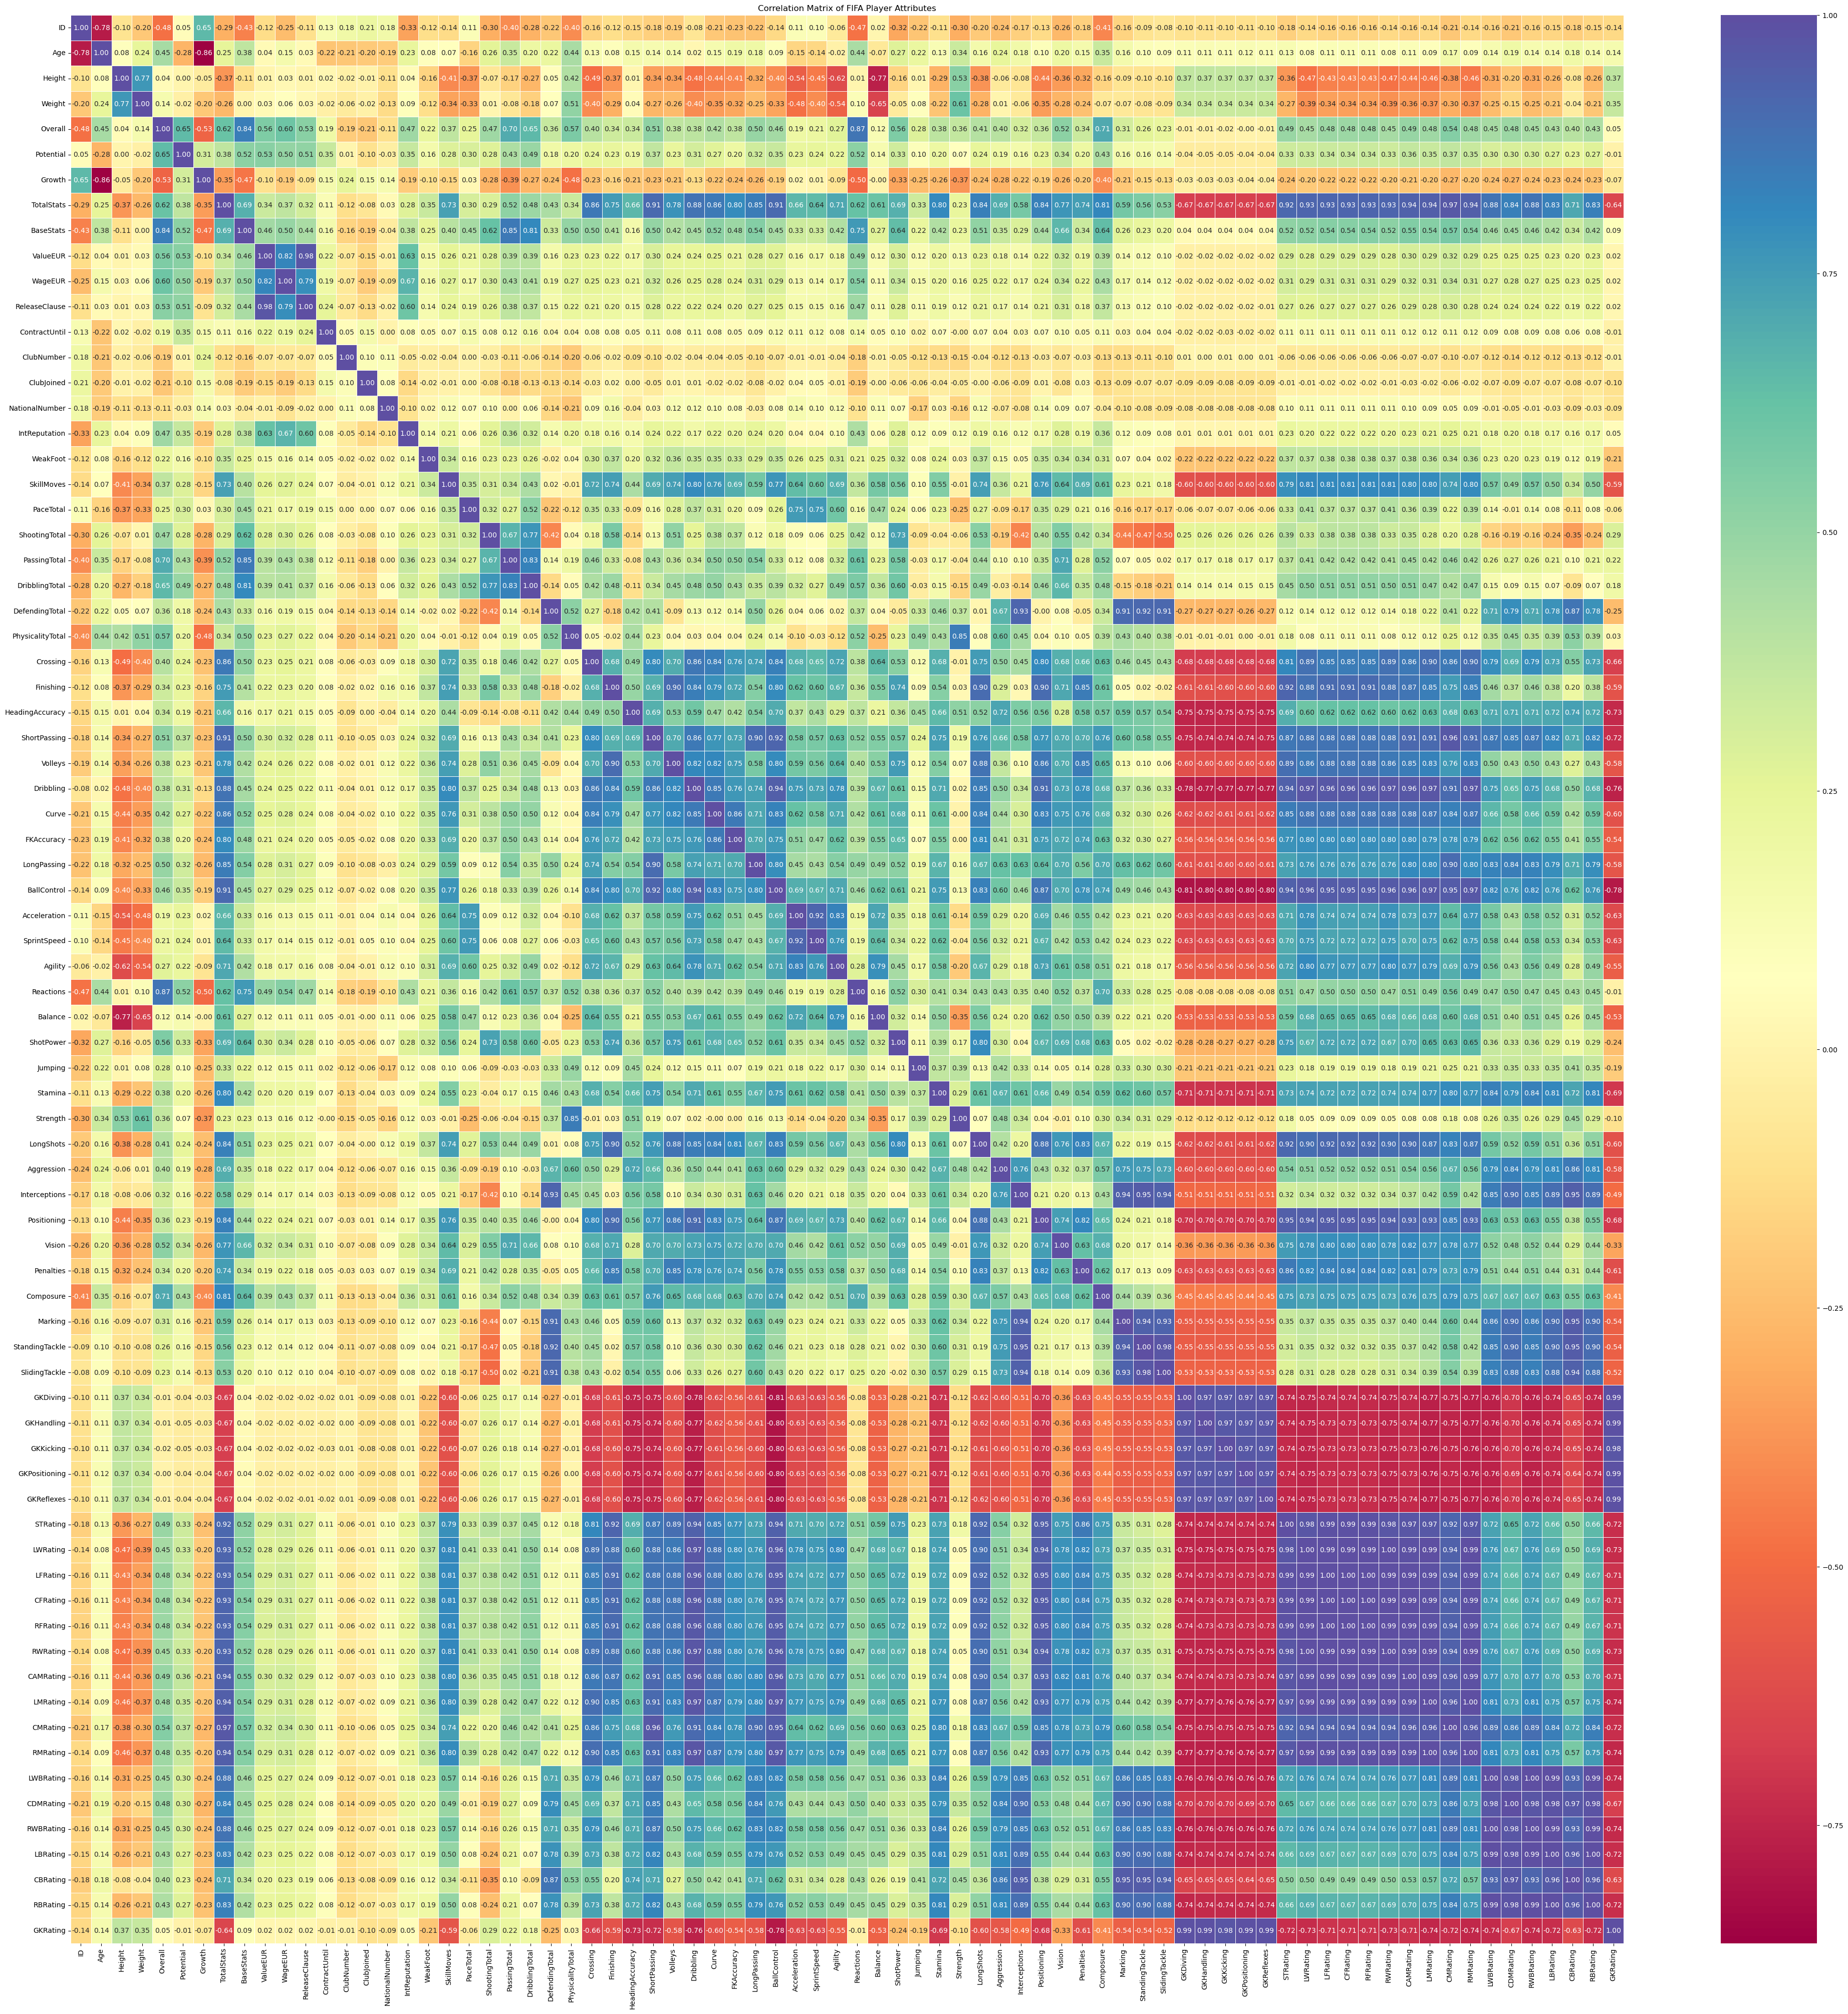

In [ ]:
# # select all numerical columns
# df_num = df.select_dtypes(include=[np.number])
# corr_num = df_num.corr()
# plt.figure(figsize=(50, 50))
# sns.heatmap(corr_num, annot=True, cmap='Spectral', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix of FIFA Player Attributes')
# plt.show()

####  Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?

#### Let's take a look at column correlations
- Players potential correlates with their stats and is most affected by the `Overall` column.

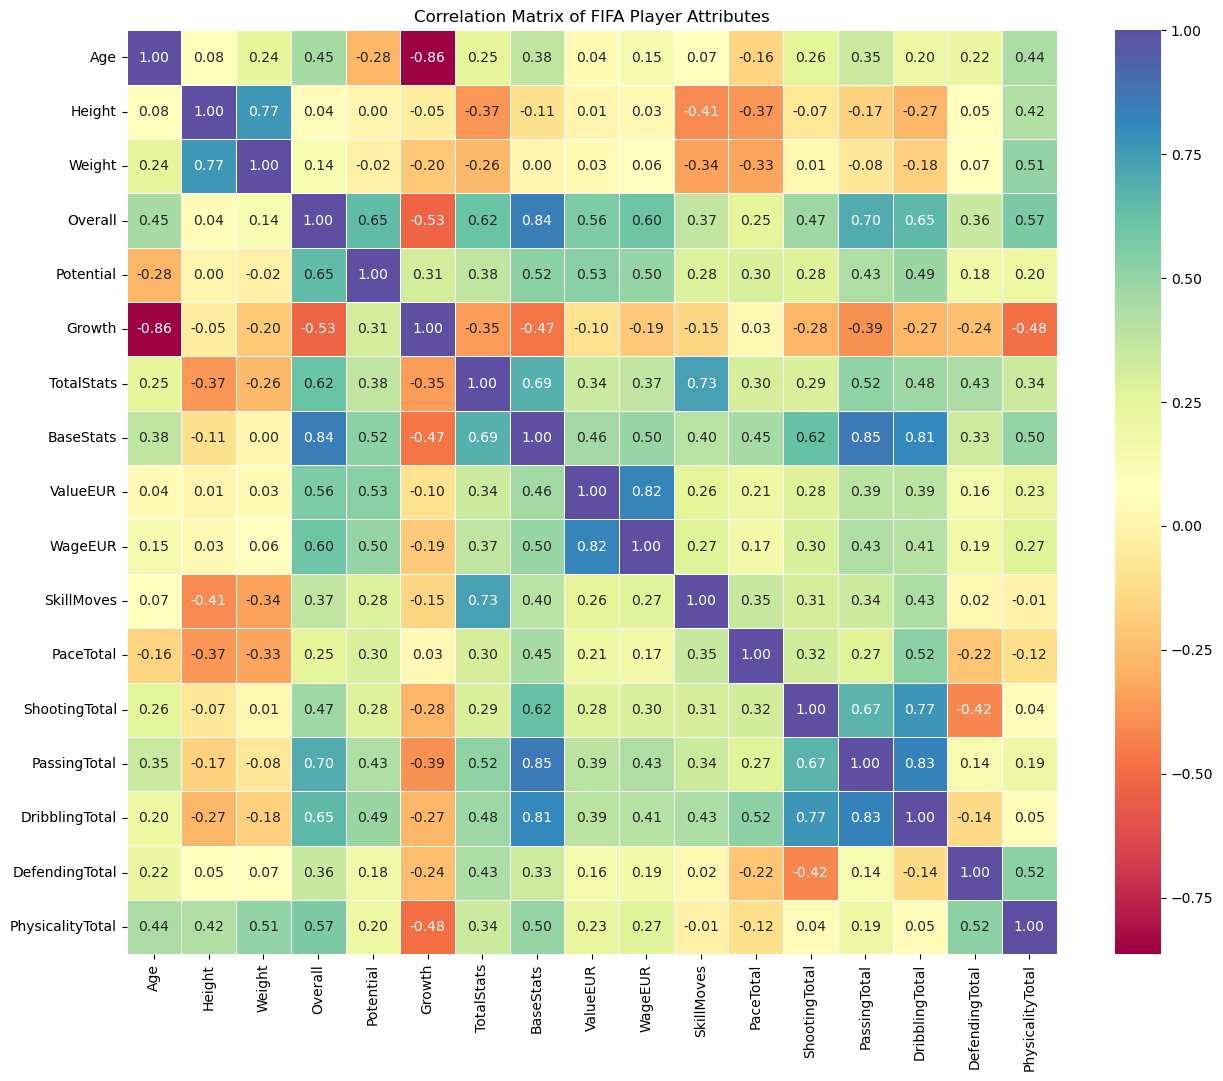

In [43]:
corr_matrix = df_main.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Spectral', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of FIFA Player Attributes')
plt.show()

#### Hypothesis 1
- Players with higher potential ratings are typically younger and command a higher market value.
    - Players with higher potential command a higher market value 

C:\Users\maste\AppData\Local\Temp\ipykernel_8472\658151152.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=axes[1], x='Age', y='Potential', data=df_main, palette='coolwarm')
C:\Users\maste\AppData\Local\Temp\ipykernel_8472\658151152.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=axes[2], x='Potential', y='ValueEUR', data=df_main, palette='coolwarm', size=5)


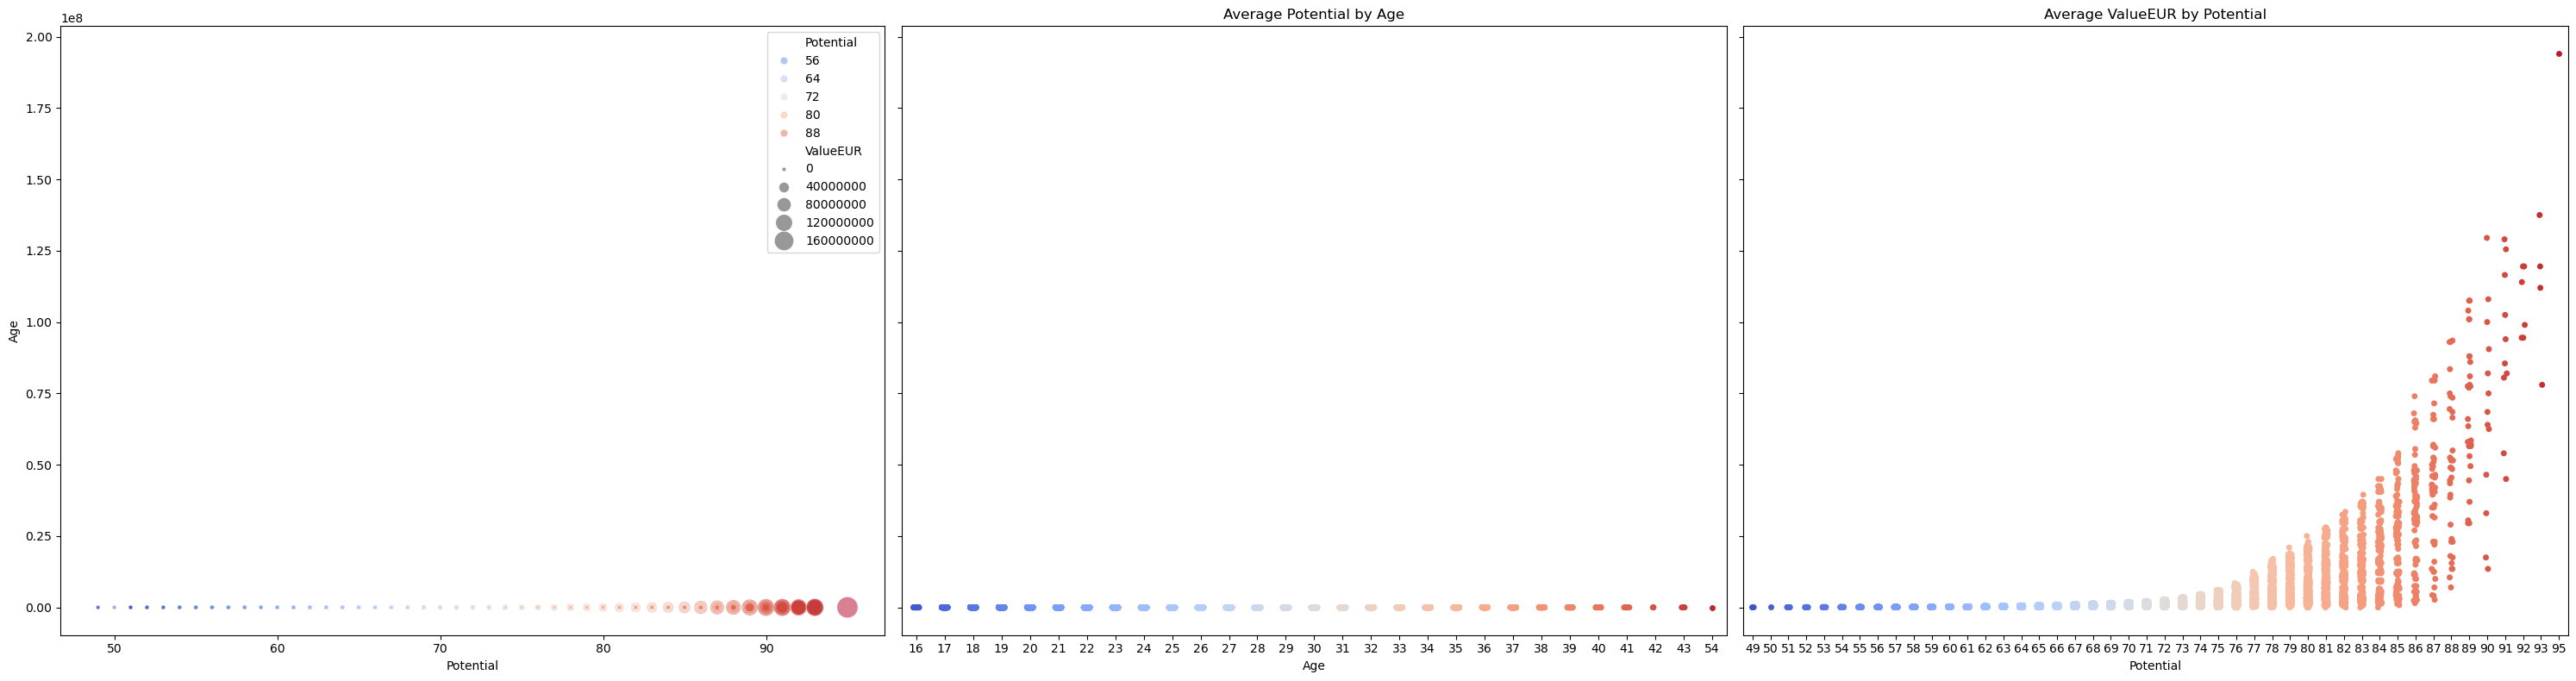

In [89]:
# plt.figure(figsize=(15, 10))
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)


# sns.scatterplot(ax=axes[0] , x='Potential', y='Age', data=df_main, alpha=0.5, hue='Potential', palette='coolwarm', size='ValueEUR', sizes=(10, 300))
# axes[0].set_title('Potential, Age and ValueEUR')

sns.scatterplot(ax=axes[0], x='Potential', y='Age', data=df_main, alpha=0.5, hue='Potential', palette='coolwarm', size='ValueEUR', sizes=(10, 300))

sns.stripplot(ax=axes[1], x='Age', y='Potential', data=df_main, palette='coolwarm')
axes[1].set_title('Average Potential by Age')

# sns.barplot(ax=axes[2], x='Potential', y='ValueEUR', data=df_main, palette='coolwarm')
sns.stripplot(ax=axes[2], x='Potential', y='ValueEUR', data=df_main, palette='coolwarm', size=5)
axes[2].set_title('Average ValueEUR by Potential')




plt.tight_layout()
plt.show()

